<h1>DC Machine in State Space</h1>
<h2>System definition</h2>
<p>This notebook presents different aspects of design of controlling a DC machine in the state space<br>
The analysis will be performed first without external disturbance and then adding a resistive torque<br>
First of all we introduce the model of the DC Machine</p>


In [47]:
clear all

% Winding resistance
R = 1;

% Winding inductance
L = 0.01;

% EMF Constant
Vn = 300
Wn = 500
K = Vn/Wn

% Mechanincal Inertia
J = 0.001

%Mechanical losses
Km = 0.001


Vn =  300
Wn =  500
K =  0.60000
J =  0.0010000
Km =  0.0010000


<p>Then we build the state space rappresentation with current and speed as state variables</p>



In [48]:
% Set the Octave Engine to run the simulation
SetSimulationEnvironment;

A = [-R/L -K/L; K/J -Km/J]
B = [1/L; 0]
C = [1 0; 0 1]
D = [0; 0]


A =

  -100   -60
   600    -1

B =

   100
     0

C =

   1   0
   0   1

D =

   0
   0



<h2>Continuous-time design</h2>
<p>As first step we need to check the controllability of the system<br>
To this purpose it is important that the rank of the matrix is equal to the order of the system</p>

In [49]:
Sc = [B A*B]
rank(Sc)

Sc =

     100  -10000
       0   60000

ans =  2


<p>Another key information is the evaluation of the eigenvalues in open loop</p>

In [50]:
eigs(A)

ans =

   -50.50 + 183.17i
   -50.50 - 183.17i



Let us first define some specifications

In [51]:
% Raise time
Ts = 5e-3

% Overshoot
M = 0.1

om = pi/(2*Ts)
alfa = (log(M)/pi)^2
csi= sqrt(alfa/(1+alfa))

p1 = -csi*om+1j*om*sqrt(1-csi*csi)
p2 = -csi*om-1j*om*sqrt(1-csi*csi)

Ts =  0.0050000
M =  0.10000
om =  314.16
alfa =  0.53719
csi =  0.59116
p1 = -185.72 + 253.39i
p2 = -185.72 - 253.39i


<p>To close the loop, we specify the pole position and calculate the gain of the feedback</p>

In [52]:
pt = [p1 p2];
Kf = place(A,B,pt)

Kf =

   2.7043   1.0388



<p>Simulation can be used to verify the system behavior <br>
First we simulate the free evolution of the system in open loop</p>

<img src="DCOpenLoop.svg" alt="drawing" width="600"  height="300"/>

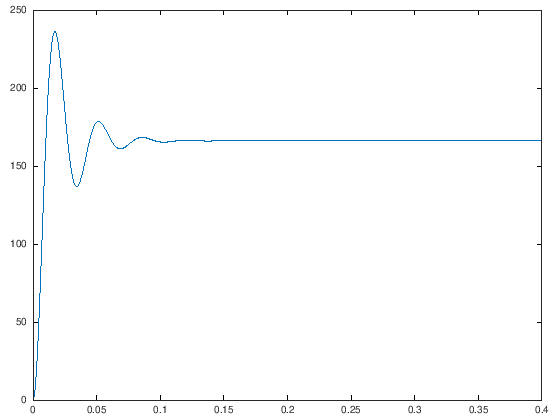

In [53]:
% Simulation Parameters
% Start time
tini = 0;
% End time
tfinal = 0.4;
% Time Step
dt = 0.00005;
% Number of data flows in the schematic
nflows = 3;


xo = [0; 0];

% Instance of the simulation schematic
sc1 = Schema(tini,tfinal,dt,nflows);

% List of components
c1{1} = Constant(1,100);
c1{2} = StateSpace(1,[2, 3],A,B,C,D,xo);

sc1.AddListComponents(c1);

% Run the schematic and plot
out1 = sc1.Run([1,3]);
plot(out1(1,:),out1(3,:));

<p>The previous simulation was performed in open loop.<br>
Another aspect is the study of systems for which we want to set a specific reference<br>
First of all we need to rescale the gain of the reference to make the overall gain unity</p>

In [54]:
% We assume the speed as variable of interest
C3 = [0 1];
V = inv(C3*inv(B*Kf-A)*B)

V =  1.6449


<p>Next simulation analyses the closed-loop behaviour given a step to reference<br>
We expect to find then a modified steady state and equal to step value of the input</p>

<img src="DCClosedLoop.svg" alt="drawing" width="600"  height="300"/>

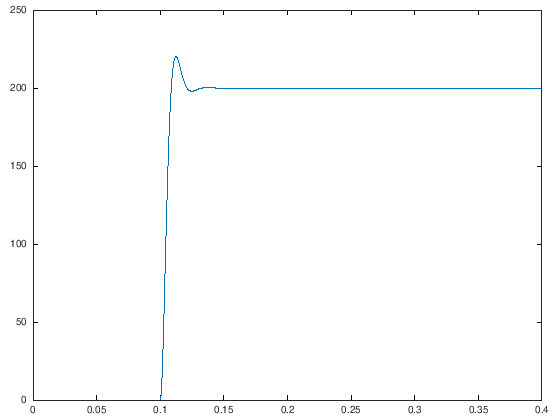

In [55]:
% Number of data flows in the schematic
nflows2 = 6;

% Instance of the simulation schematic
sc3 = Schema(tini,tfinal,dt,nflows2);

% List of components
c3{1} = StepSource(1,0,200,0.1);
c3{2} = Gain(1,2,V);
c3{3} = Sum(2,3,4,1,-1); 
c3{4} = StateSpace(4,[5 6],A,B,C,D,xo);
c3{5} = Gain([5 6],3,Kf);

sc3.AddListComponents(c3);

% Run the schematic and plot
out3 = sc3.Run([6 4]);
plot(out3(1,:),out3(2,:));

<p>The system reaches properly the referenc value<br>
   Another aspect is also to analyse the effort of the input channel (voltage)
</p>

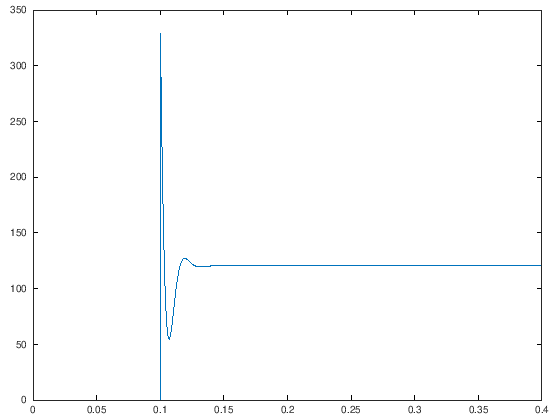

In [56]:
plot(out3(1,:),out3(3,:));

<p>Let us now add a disturbance, i.e. a resistive torque</p>

B2 =

    100      0
      0  -1000

D2 =

   0   0
   0   0



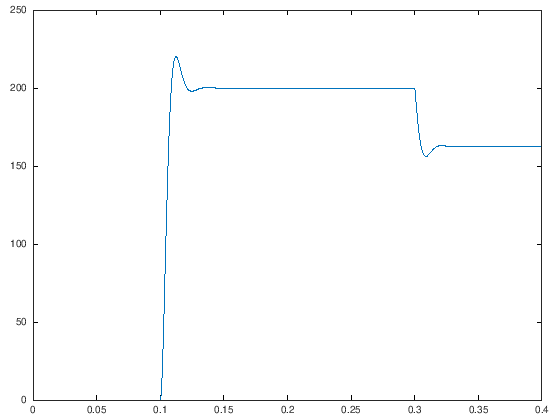

In [57]:
% Number of data flows in the schematic
nflows3 = 7;

% Instance of the simulation schematic
sc3 = Schema(tini,tfinal,dt,nflows3);

% Adding as input the resistive torque
B2 = [1/L 0; 0 -1/J]
D2 = [0 0; 0 0]

% List of components
c3{1} = StepSource(1,0,200,0.1);
c3{2} = Gain(1,2,V);
c3{3} = Sum(2,3,4,1,1);
c3{4} = StepSource(7,0,10,0.3);
c3{5} = StateSpace([4 7],[5 6],A,B2,C,D2,xo);
c3{6} = Gain([5 6],3,-Kf);

sc3.AddListComponents(c3);

% Run the schematic and plot
out3 = sc3.Run([6]);
plot(out3(1,:),out3(2,:));

<p>The control can not compensate the disturbance. We need to add an integration action<br>
For this reason we need a new state variable and to perform the design again<br>
Let us start defining the new system</p>

In [58]:
Ae = [-R/L -K/L 0; K/J -Km/J 0; 0 1 0]
Be = [1/L; 0; 0]

Ae =

  -100   -60     0
   600    -1     0
     0     1     0

Be =

   100
     0
     0



<p>We need to check again the controllability</p>

In [59]:
Sce = [Be Ae*Be Ae*Ae*Be]
rank(Sce)

Sce =

       100    -10000  -2600000
         0     60000  -6060000
         0         0     60000

ans =  3


<p>We repeat then the design for the new system and one more pole in the specification</p>

In [60]:
p3 = -1000
pte = [p1 p2 p3];
Kfe = acker(Ae,Be,pte)

p3 = -1000
Kfe =

     12.7043      7.2127   1644.9341



<p>Now we repeat the simulation in closed loop with the integrator</p>

<img src="DCClosedLoopIntegral.svg" alt="drawing" width="600"  height="300"/>

B2 =

    100      0
      0  -1000

D2 =

   0   0
   0   0



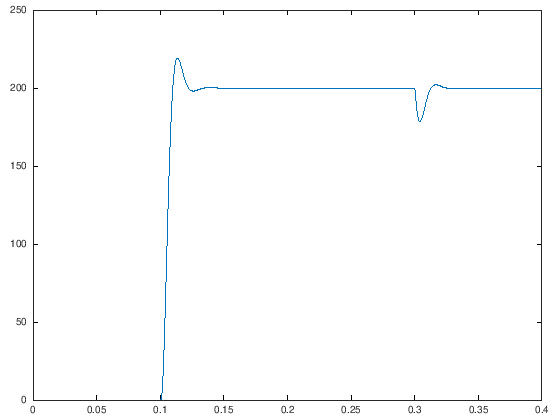

In [61]:
% Number of data flows in the schematic
nflows4 = 10;

% Instance of the simulation schematic
sc4 = Schema(tini,tfinal,dt,nflows4);

% Adding as input the resistive torque
B2 = [1/L 0; 0 -1/J]
D2 = [0 0; 0 0]

% List of components
c4{1} = StepSource(1,0,200,0.1);
c4{2} = Sum(1,9,2,-1,1);
c4{3} = Integrator(2,3,0);
c4{4} = Gain(3,5,-Kfe(3));
c4{5} = Sum(10,5,7,1,1);
c4{6} = StepSource(6,0,10,0.3);
c4{7} = StateSpace([7 6],[8 9],A,B2,C,D2,xo);
c4{8} = Gain([8 9],10,[-Kfe(1) -Kfe(2)]);

sc4.AddListComponents(c4);

% Run the schematic and plot
out4 = sc4.Run([9]);
plot(out4(1,:),out4(2,:));

<p>Simulation results confirm the theoretical assumptions</p>

<p>Now let us suppose to consider an optimal control approach<br>
We assume to use an LQR approach</p>

In [62]:
% Weight for the current
Wi = 1

% Weight for the speed
Wo = 10

%Weight for the input
Wu = 0.1

Q = [Wi 0 ; 0 Wo]
R = Wu


Klqr = lqr(A,B,Q,R)

Wi =  1
Wo =  10
Wu =  0.10000
Q =

    1    0
    0   10

R =  0.10000
Klqr =

   10.1263    9.3995



We can check the equivalent position of the poles

In [63]:
plqr = eigs(A-B*Klqr)

plqr =

  -556.81 + 539.48i
  -556.81 - 539.48i



By looking at these poles we can also track back the performance we should expect. In particular the raising time

In [64]:
omlqr = sqrt(plqr(1)*plqr(2))
Tslqr = pi/(2*omlqr)

omlqr =  775.30
Tslqr =  0.0020261


We can now simulate and check

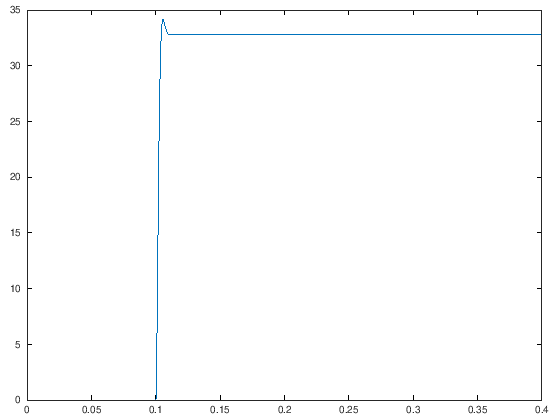

In [65]:
% Number of data flows in the schematic
nflows5 = 6;

% Instance of the simulation schematic
sc5 = Schema(tini,tfinal,dt,nflows5);

% List of components
c5{1} = StepSource(1,0,200,0.1);
c5{2} = Gain(1,2,V);
c5{3} = Sum(2,3,4,1,-1); 
c5{4} = StateSpace(4,[5 6],A,B,C,D,xo);
c5{5} = Gain([5 6],3,Klqr);

sc5.AddListComponents(c5);

% Run the schematic and plot
out5 = sc5.Run([6 4]);
plot(out5(1,:),out5(2,:));

Let us play with the gain matrices to understand their role

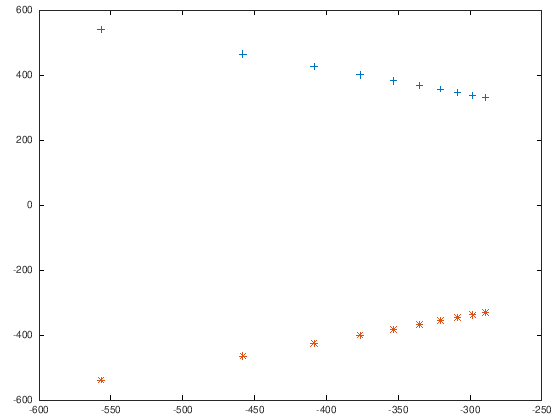

In [73]:
% calculate poles for a variety of values for R
clear plqre
for p=1:10
    Wu=0.1*p;
    
    Re = Wu;
    Klqre = lqr(A,B,Q,Re);
    plqre(:,p) = eigs(A-B*Klqre);
end

plot(real(plqre(1,:)),imag(plqre(1,:)),'+',real(plqre(2,:)),imag(plqre(2,:)),'*')

    